<h1>Problema<h1>

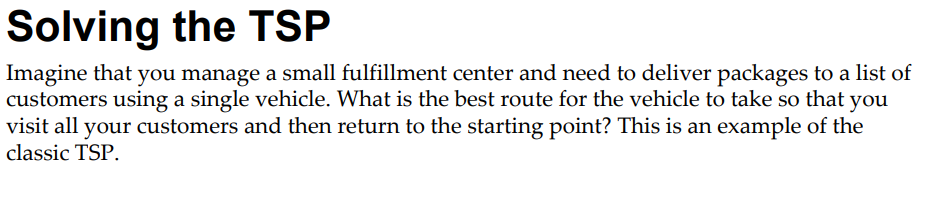

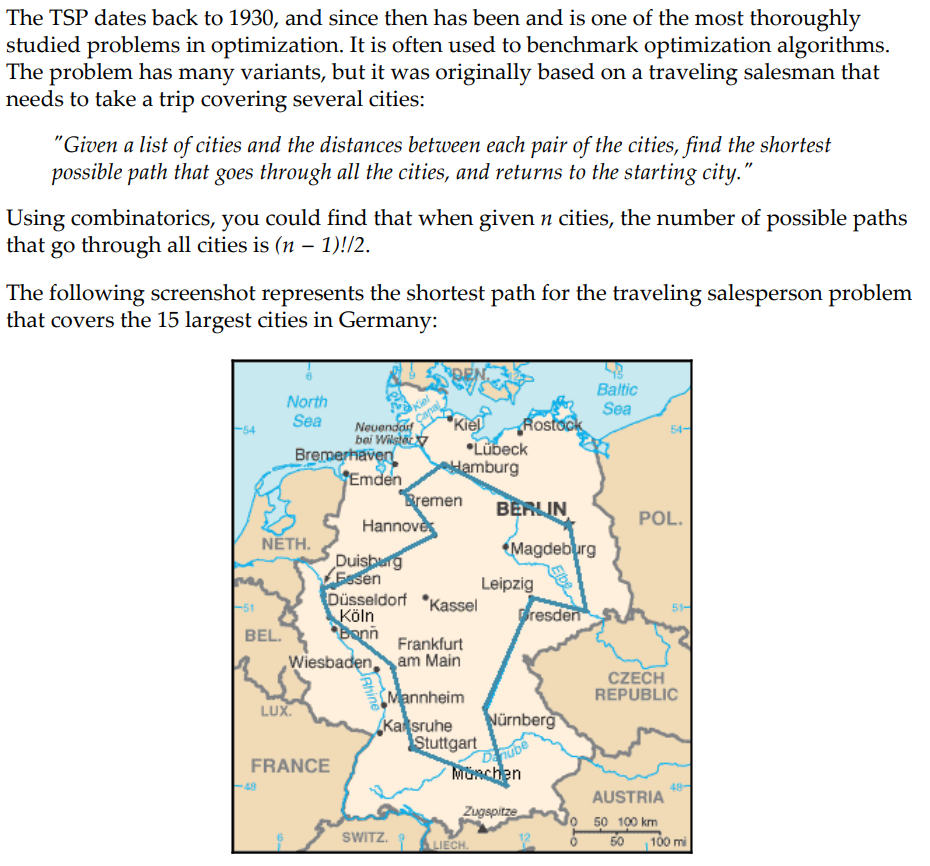

In [ ]:
!pip install deap
!pip install matplotlib
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>TSP class<h1>

Problem name: bayg29
Optimal solution =  [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
Optimal distance =  9074.147


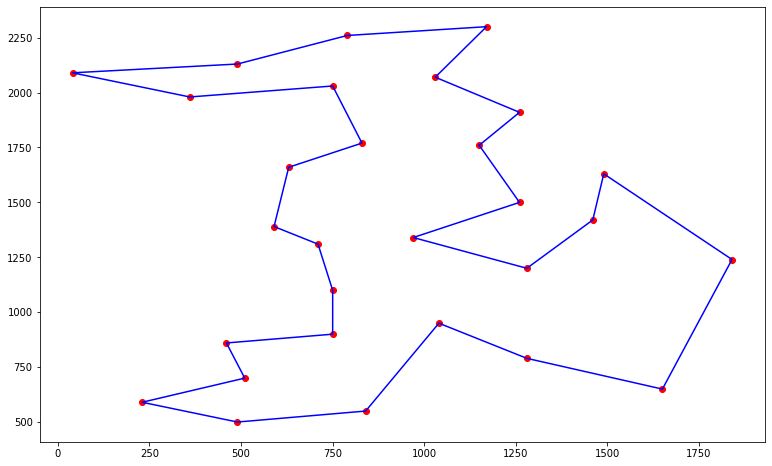

In [ ]:
import csv
import pickle
import os
import codecs

import numpy as np

from urllib.request import urlopen

import matplotlib.pyplot as plt


class TravelingSalesmanProblem:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from an online file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.
    :param name: The name of the corresponding TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """

    def __init__(self, name):
        """
        Creates an instance of a TSP
        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the serialized data, and if not available - calls __create_data() to prepare it
        """

        # attempt to read serialized data:
        try:
            self.locations = pickle.load(open(os.path.join("tsp-data", self.name + "-loc.pickle"), "rb"))
            self.distances = pickle.load(open(os.path.join("tsp-data", self.name + "-dist.pickle"), "rb"))
        except (OSError, IOError):
            pass

        # serailized data not found - create the data from scratch:
        if not self.locations or not self.distances:
            self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file from the Internet, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        It then serializes the city locations and the calculated distances to disk using the pickle utility.
        """
        self.locations = []

        # open whitespace-delimited file from url and read lines from it:
        with urlopen("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + self.name + ".tsp") as f:
            reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))

            # serialize locations and distances:
            if not os.path.exists("tsp-data"):
                os.makedirs("tsp-data")
            pickle.dump(self.locations, open(os.path.join("tsp-data", self.name + "-loc.pickle"), "wb"))
            pickle.dump(self.distances, open(os.path.join("tsp-data", self.name + "-dist.pickle"), "wb"))

    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities
        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices):
        """plots the path described by the given indices of the cities
        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.figure(figsize=(13,8))
        plt.scatter(*zip(*self.locations), marker='o', color='red')
        

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')
        plt.show()

        return plt


# testing the class:
def main():
    # create a problem instance:
    tsp = TravelingSalesmanProblem("bayg29")

    # generate a random solution and evaluate it:
    #randomSolution = random.sample(range(len(tsp)), len(tsp))

    # see http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.opt.tour
    optimalSolution = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]

    print("Problem name: " + tsp.name)
    print("Optimal solution = ", optimalSolution)
    print("Optimal distance = ", tsp.getTotalDistance(optimalSolution))

    # plot the solution:
    plot = tsp.plotData(optimalSolution)
    plot.show()


if __name__ == "__main__":
    main()

In [ ]:
indices = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
tsp = TravelingSalesmanProblem("bayg29")
distance = tsp.getTotalDistance([0,27])
print(distance)

372.0215


<h1>TPS taking data from my own way

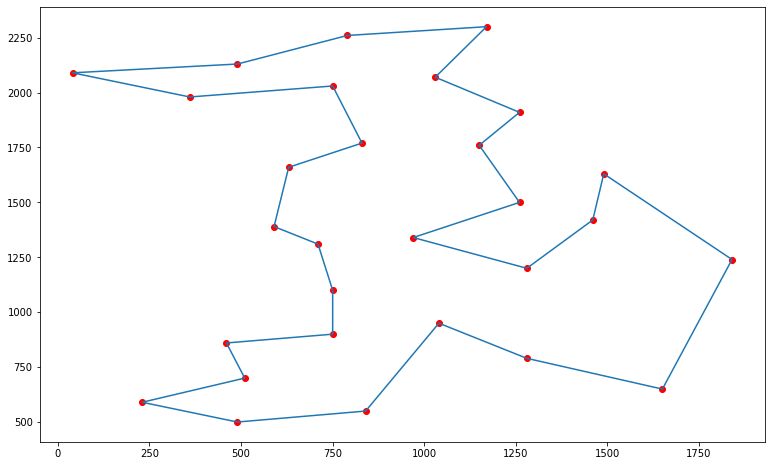

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from pprint import pprint
import matplotlib.pyplot as plt

# Taking data
req = requests.get("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.tsp")
site = BeautifulSoup(req.content, "html.parser").text
informations = re.findall(r"^\s+\d+\s+\d+.0\s+\d+.0$", site, flags=re.MULTILINE)

# Taking cities and points
cities = []
for i in informations:
  i = list(map(lambda x: int(float(x)), i.strip().split()))
  cities.append(i)
# pprint(cities)

# Plotting
x = [i[1] for i in cities]
y = [i[2] for i in cities]
plt.figure(figsize=(13,8))
plt.scatter(x, y, marker='o', color="red")
Optimal_solution =  [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
Optimal_solution.append(Optimal_solution[0])
x_new = [cities[i][1] for i in Optimal_solution]
y_new = [cities[i][2] for i in Optimal_solution]
plt.plot(x_new, y_new)
plt.show()


No handles with labels found to put in legend.


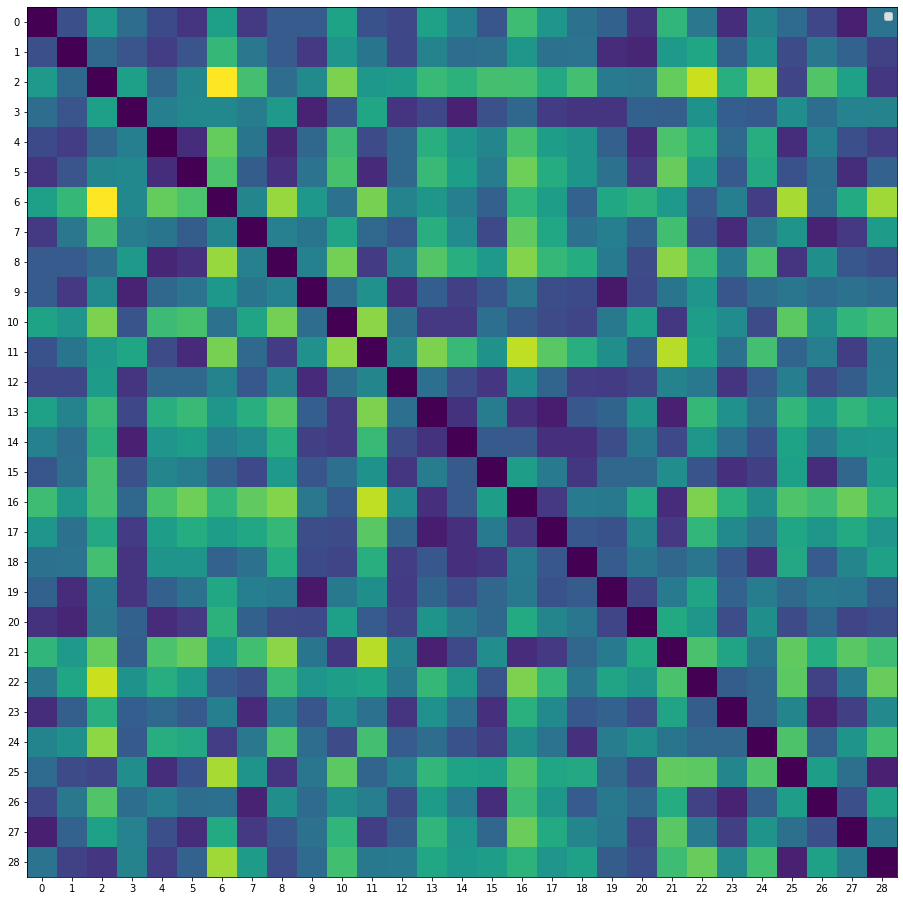

In [ ]:
# Making the matrix of distances
matrix = [[0 for i in range(len(cities))] for i in range(len(cities))]
for y in range(len(matrix)):
  for x in range(len(matrix[0])):
    matrix[y][x] = ((cities[y][1]-cities[x][1])**(2) + (cities[y][2]-cities[x][2])**2)**(1/2)

"""for i in matrix:
  print(i, "\n")"""

plt.figure(figsize=(16,16))
plt.imshow(matrix)
plt.xticks(ticks=[i for i in range(len(cities))])
plt.yticks(ticks=[i for i in range(len(cities))])
plt.legend()
plt.show()